In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Dense, Attention, LSTM, Dropout, Lambda, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model, config
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K
import joblib
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('data_for_lstm_model3.csv', index_col='Date', parse_dates=True)
data.sort_index(inplace=True)
data.head()

,Modal Price (Rs./Quintal),Variety_(Red Nanital),Variety_Chips,Variety_Desi,Variety_Jyoti,Variety_Local,Variety_Other,Variety_Potato,Variety_Red,trend,seasonal,residual,rolling_mean,rolling_std,rolling_sum,modal_boxcox
Date,,,,,,,,,,,,,,,,
2002-11-16,600.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,591.000000,1.476728,7.523272,594.0,30.307943,8910.0,6.626189
2002-11-17,600.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,593.166667,0.567195,6.266138,594.0,30.307943,8910.0,6.626189
2002-11-18,600.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,594.500000,14.315802,-8.815802,594.0,30.307943,8910.0,6.626189
2002-11-19,525.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,595.833333,-0.714997,-70.118337,594.0,30.307943,8910.0,6.483078
2002-11-20,625.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,597.166667,14.212380,13.620954,594.0,30.307943,8910.0,6.669982


In [3]:
split_time = '2024-03-31'
train_df = data.loc[: split_time]
test_df = data.loc[split_time :]

In [4]:
# scaler3 = MinMaxScaler()
# scaled_train_df = scaler3.fit_transform(train_df)
# scaled_test_df = scaler3.transform(test_df)

# # Save the scaler to a file
# with open('minmax_scaler3.pkl', 'wb') as f:
#     pickle.dump(scaler3, f)

scaler3 = RobustScaler()
scaled_train_df = scaler3.fit_transform(train_df)
scaled_test_df = scaler3.transform(test_df)

# Save the scaler to a file
with open('robust_scaler3.pkl', 'wb') as f:
    pickle.dump(scaler3, f)

In [5]:
def create_database(data, lookback):
    X, y = [], []

    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])  # Include all features including the target price
        y.append(np.mean(data[i-lookback:i, :], axis=0))  # Calculate the mean of the lookback period for each feature

    return np.array(X), np.array(y)

In [6]:
lookback = 4

X_train, y_train = create_database(scaled_train_df, lookback)
X_test, y_test = create_database(scaled_test_df, lookback)

In [7]:
print(X_train.shape, y_train.shape)

(7801, 4, 16) (7801, 16)


In [8]:
## define the model file and input shape
input_shape = (X_train.shape[1], X_train.shape[2])
print(input_shape)

(4, 16)


In [9]:
class PrintHyperparametersAndPredictions(Callback):
    def __init__(self, validation_data=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if validation_data is not None:
            self.X_val, self.y_val = validation_data
        else:
            self.X_val = self.y_val = None

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        if hasattr(self.model, 'hyperparameters'):
            hp = self.model.hyperparameters
            print(f"Epoch {epoch + 1}:")
            print(f"Hyperparameters: {hp.values}")

        # Predict and print last 10 predictions
        if self.X_val is not None and self.y_val is not None:
            y_pred = self.model.predict(self.X_val)
            print(f"Last 10 Predictions: {y_pred[-10:]}")

In [10]:
## Define lstm_attention model...
def create_lstm_attention_model(hp):

    # define hyperparameter tunning..
    units = hp.Int('units', min_value = 64, max_value=512, step = 32)
    dropout_rate = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.5, step = 0.1)
    learning_rate = hp.Float('learning_rate', min_value = 1e-6, max_value = 1e-2, sampling = 'log')
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)


    ## lets define the layer architecture
    inputs = Input(shape = input_shape)

    ## LSTM layers
    lstm_out = LSTM(units, return_sequences=True, kernel_regularizer=l2(0.10))(inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    ## Attention model
    attention = Attention()([lstm_out, lstm_out])

    # context vector
    # context_vector = Lambda(custom_lambda_function, output_shape = (1, units))(attention)

    ## lstm layer to process context vector
    lstm_out = LSTM(units//2, return_sequences=False, kernel_regularizer = l2(0.01))(attention)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # output layers
    outputs = LeakyReLU(negative_slope = 0.1)(lstm_out)
    outputs = Dense(16)(outputs)

    ## compile the model
    model = Model(inputs = inputs, outputs=outputs)

    # ## Define adam optimization
    # optimizer = Adam(
    # learning_rate=learning_rate,
    # beta_1=hp.Float('beta_1', min_value=0.8, max_value=0.99, step=0.01),
    # beta_2=hp.Float('beta_2', min_value=0.9, max_value=0.999, step=0.01),
    # epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log')
    # )

    # Define RMSprop optimizer
    optimizer = RMSprop(
        learning_rate=learning_rate,
        rho=hp.Float('rho', min_value=0.8, max_value=0.99, step=0.01),
        momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1),
        epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log')
    )

    ## Compile the model
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')

    return model

In [11]:
#define a function to call and train above model...

def tune_model_with_kerastuner(X_train, y_train):
    tuner = RandomSearch(
        create_lstm_attention_model,
        objective = 'val_loss',
        max_trials = 15,
        executions_per_trial = 3,
        directory = 'my_dir',
        project_name = 'attention_lstm'
    )


    ## defining reduce-lr-on-plateau
    reduce_lr = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 5,
        min_lr = 1e-6,
        verbose = 1
    )

    ## define early-stopping...
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights=True,
        verbose=1
    )

    ## model checkpoints
    model_checkpoint = ModelCheckpoint(
        'best_model_with_kerastuner3.keras',
        monitor = 'val_loss',
        save_best_only=True,
        verbose=1
    )

    ## perform the hyperparameter tunning
    print(f'Model training starts...')
    tuner.search(
        X_train, y_train,
        epochs = 60,
        validation_split = 0.2,
        callbacks = [reduce_lr, early_stopping, model_checkpoint, PrintHyperparametersAndPredictions()]
    )
    print(f'Model tuning complete!')
    ## Retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    print(f'best model found!')

    return best_model, tuner


In [12]:
## make prediction and evaludate...
def make_prediction_and_evaluate(model, X_test, y_test):
    # maek prediction
    y_pred = model.predict(X_test)

    ## evaluate model
    loss = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss : {loss}')

    ## plot prediction vs actual
    plt.figure(figsize=(12,6))
    plt.plot(y_test, label = 'Actual Values')
    plt.plot(y_pred, lable = 'Predicted Values')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.savefig('actaul_vs_prediction_plot.png')
    plt.show()

In [13]:
model_file = 'best_model_with_kerastuner3.keras'

if os.path.exists(model_file):
    print(f'Loading existing model from {model_file}')

    try:
        best_model = load_model(model_file)
        print("Model loaded successfully.")

    except Exception as e:
        print(f'Error loading model: {e}')
        best_model = None

else:
    print('No existing model found. Training a new model...')

    try:
        best_model, tuner = tune_model_with_kerastuner(X_train, y_train)
        if best_model:
            best_model.save(model_file)
            print(f'Model saved to {model_file}')

        else:
            print('Failed to train the model.')
    except Exception as e:
        print(f'Error during model training: {e}')


Loading existing model from best_model_with_kerastuner3.keras
Model loaded successfully.


C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [14]:
model = best_model
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step


In [15]:
y_pred.shape

(82, 16)

In [16]:
y_pred1 = y_pred[:, 0]
y_test1 = y_test[:, 0]

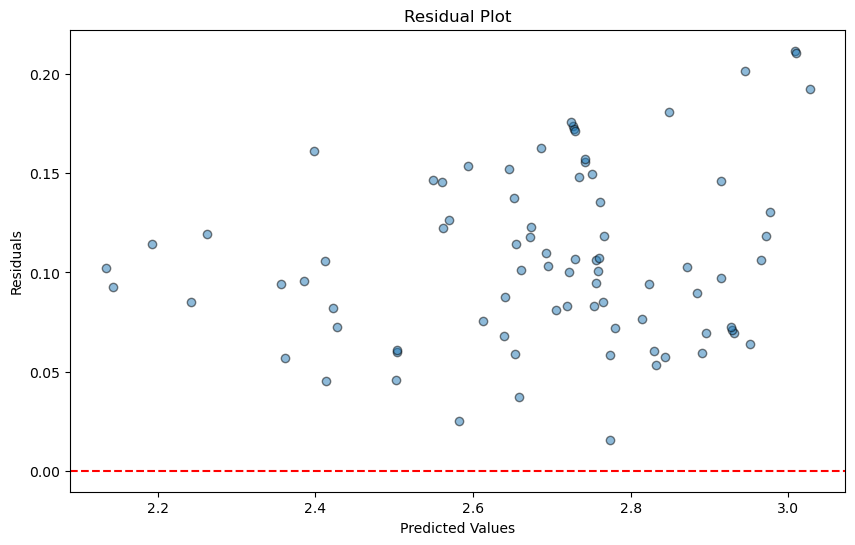

In [17]:
residuals = y_test1 - y_pred1

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred1, residuals, alpha=0.5, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('residual_of_model3.png')
plt.show()

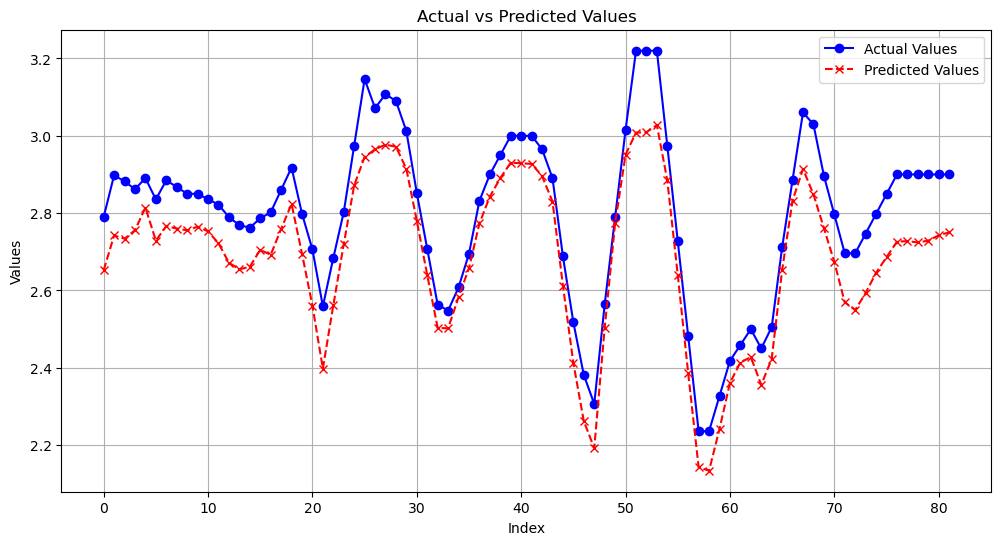

In [18]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot actual vs predicted values
plt.plot(y_test1, label='Actual Values', color='blue', linestyle='-', marker='o')
plt.plot(y_pred1, label='Predicted Values', color='red', linestyle='--', marker='x')

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid()
plt.savefig('real_vs_pred_model3.png')
# Show plot
plt.show()

In [19]:
y_test1

array([2.79  , 2.898 , 2.882 , 2.862 , 2.8905, 2.8355, 2.885 , 2.8675,
       2.85  , 2.85  , 2.836 , 2.822 , 2.7895, 2.769 , 2.7625, 2.7865,
       2.802 , 2.86  , 2.918 , 2.7985, 2.706 , 2.559 , 2.684 , 2.8025,
       2.9745, 3.1465, 3.0715, 3.1075, 3.09  , 3.012 , 2.852 , 2.7075,
       2.563 , 2.548 , 2.608 , 2.695 , 2.832 , 2.9   , 2.95  , 3.    ,
       3.    , 3.    , 2.9655, 2.8905, 2.688 , 2.5175, 2.3815, 2.3065,
       2.564 , 2.7895, 3.015 , 3.22  , 3.22  , 3.22  , 2.974 , 2.728 ,
       2.482 , 2.236 , 2.236 , 2.327 , 2.418 , 2.459 , 2.5   , 2.45  ,
       2.505 , 2.7115, 2.886 , 3.0605, 3.0295, 2.897 , 2.7965, 2.696 ,
       2.696 , 2.747 , 2.798 , 2.849 , 2.9   , 2.9   , 2.9   , 2.9   ,
       2.9   , 2.9   ])

In [20]:
y_pred1

array([2.652244 , 2.7423086, 2.733823 , 2.7558398, 2.8142204, 2.728952 ,
       2.7664084, 2.7601323, 2.7555227, 2.7650018, 2.7528708, 2.7220325,
       2.6718135, 2.6545868, 2.6614196, 2.7052336, 2.6920216, 2.759103 ,
       2.8236165, 2.6951303, 2.5605984, 2.3979657, 2.561471 , 2.7195415,
       2.871858 , 2.9451423, 2.9651077, 2.9770923, 2.9716728, 2.9146037,
       2.7799819, 2.6395793, 2.5033395, 2.502034 , 2.582795 , 2.6579416,
       2.7735455, 2.8428793, 2.890752 , 2.930473 , 2.9289384, 2.9272993,
       2.8958938, 2.830042 , 2.6125445, 2.4119625, 2.2619982, 2.1923823,
       2.5032108, 2.7738364, 2.9512942, 3.0081968, 3.0091157, 3.0274858,
       2.8845623, 2.640606 , 2.3861377, 2.143101 , 2.1338394, 2.2417355,
       2.3610704, 2.4135718, 2.427667 , 2.3558583, 2.4228723, 2.6527617,
       2.8325553, 2.9142907, 2.848436 , 2.7616115, 2.6735992, 2.5695667,
       2.5495622, 2.5933378, 2.6457148, 2.6860464, 2.7262368, 2.7274947,
       2.724196 , 2.7287383, 2.7425823, 2.7502787],

In [21]:
mse_overall = mean_squared_error(y_test, y_pred)
mae_overall = mean_absolute_error(y_test, y_pred)
r2_overall = r2_score(y_test, y_pred)

print("Overall Mean Squared Error:", mse_overall)
print("Overall Mean Absolute Error:", mae_overall)
print("Overall R-squared:", r2_overall)

Overall Mean Squared Error: 0.21156485176009426
Overall Mean Absolute Error: 0.2500456731613234
Overall R-squared: -0.888794753883113


In [27]:
price_actuall = scaler3.inverse_transform(y_test)
price_predicted = scaler3.inverse_transform(y_pred)          

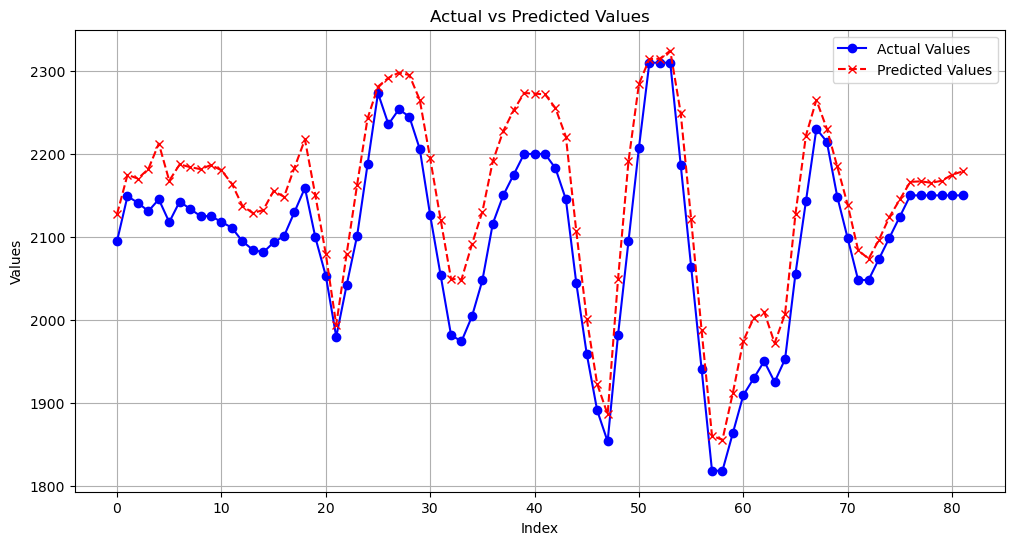

In [29]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot actual vs predicted values
plt.plot(price_actuall[:, 0], label='Actual Values', color='blue', linestyle='-', marker='o')
plt.plot(price_predicted[:, 0]*1.05, label='Predicted Values', color='red', linestyle='--', marker='x')

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid()
plt.savefig('real_vs_pred_model3.png')
# Show plot
plt.show()

In [23]:
 residuals.max()

0.21180316925048848

In [24]:
residuals.min()

0.0156636257171634

In [25]:
avg_residuals = (residuals.max() + residuals.min())/2
avg_residuals

0.11373339748382594